## Code to analyze NM output

In [1]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [8]:
dataset = "qpn"
current_release = "Oct_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# LORIS id map
loris_id_map_csv = f"{tabular_dir}/recruitment/neuromelanin_participants_VM.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# mri_info
mri_sessions_csv = f"{tabular_dir}/mri_info/mri_sessions.csv"

# NM derivatives /home/nikhil/projects/Parkinsons/qpn/derivatives/neuromelanin/
NM_summaries_csv = f"{dataset_dir}/derivatives/neuromelanin/avg_nm_values_QPN_Release_QCed_for_Nikhil.csv"

# save dirs
save_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/{dataset}/{current_release}/agg_dfs/"
figs_dir = f"{dataset_dir}/results/{session}/anat/figs/"

# Create dirs for results if they don't exist
Path(f"{save_dir}").mkdir(parents=True, exist_ok=True)
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Colormaps

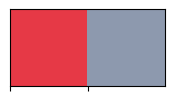

In [3]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#8d99ae"
    PD = "#e63946"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

In [4]:
def quick_QC(df, check_cols, min_val, max_val, index_col="participant_id"):
    """Checks for NaNs and out of range outliers """
    
    if index_col in df.columns:
        # check NaNs
        nan_participants = df[df[check_cols].isna().any(axis=1)][index_col].values
        n_nans = len(nan_participants)

        # check range
        outlier_participants = df[df[check_cols].apply(lambda x: (x < min_val) | (x > max_val)).any(axis=1)][index_col].values
        n_outliers = len(outlier_participants)

        print(f"found {n_nans} NaNs and {n_outliers} outliers")
        return list(nan_participants), list(outlier_participants)
    
    else:
        print(f"Provide an index column")
        return None, None

### manifest

In [5]:
manifest_cols = ["participant_id", "visit", "session"]
nipoppy_df = pd.read_csv(manifest_csv)
nipoppy_df = nipoppy_df[manifest_cols] 
nipoppy_participants = nipoppy_df["participant_id"].unique()
n_nipoppy_participants = len(nipoppy_participants)
print(f"nipoppy participants: {n_nipoppy_participants}")
nipoppy_df.head()

nipoppy participants: 306


,participant_id,visit,session
0,MNI0215,MRI_v1,ses-01
1,PD01145,MRI_v1,ses-01
2,MNI0313,MRI_v1,ses-01
3,MNI0476,MRI_v1,ses-01
4,PD01214,MRI_v1,ses-01


### Diagnosis info
- as confirmed later by the clinicians

In [75]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"][["participant_id", "diagnosis_group_for_analysis"]]

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

PD + control: 271
Control: 69
PD: 202


,participant_id,diagnosis_group_for_analysis
0,MNI0028,unknown
1,MNI0056,PD
2,MNI0058,PD
3,MNI0068,PD
4,MNI0079,PD


### LORIS ID map

In [76]:
loris_id_map_df = pd.read_csv(loris_id_map_csv)
loris_id_map_df["DCCID"] = loris_id_map_df["DCCID"].astype(str)
loris_id_map_df = loris_id_map_df.rename(columns={"Visit Label": "visit"})

demo_df = pd.merge(dx_df, loris_id_map_df, on="participant_id", how="left")
demo_df.head()

,participant_id,diagnosis_group_for_analysis,DCCID,visit,session
0,MNI0028,unknown,152209,MRI01,ses-01
1,MNI0056,PD,864854,MRI01,ses-01
2,MNI0058,PD,197308,MRI01,ses-01
3,MNI0068,PD,842090,MRI01,ses-01
4,MNI0079,PD,760662,MRI01,ses-01


### Read NM data

In [77]:
nm_df = pd.read_csv(NM_summaries_csv)
nm_df["DCCID"] = nm_df["subject_DCCID"].astype(str)

nm_participants = nm_df["DCCID"].unique()
n_nm_participants = len(nm_participants)

print(f"NM participants: {n_nm_participants}")

nm_df.head()

NM participants: 258


,subject_DCCID,visit,SN_L_AVG_NORM,SN_R_AVG_NORM,LC_L_AVG_NORM,LC_R_AVG_NORM,SN_QC_status,LC_QC_status,DCCID
0,100489,MRI01,1.171312,1.161075,1.059848,1.020894,good,good,100489
1,105910,MRI01,1.156752,1.148735,1.056938,1.004313,good,good,105910
2,106182,MRI01,1.140080,1.149656,1.066699,1.061651,good,good,106182
3,115903,MRI01,1.140439,1.136561,1.067481,1.014369,good,good,115903
4,115903,MRI02,1.132277,1.124527,1.033382,1.017449,good,good,115903


### Merge with demographics

In [78]:
nm_df = pd.merge(demo_df, nm_df, on=["DCCID", "visit"], how="left")

control_participants = nm_df[nm_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = nm_df[nm_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

# Check for NaNs and outliers
missing_NM_participants = nm_df[(nm_df["diagnosis_group_for_analysis"] != "unknown") & 
                                (nm_df["SN_L_AVG_NORM"].isna())]["participant_id"].values

print(f"missing NM values for {len(missing_NM_participants)} participants")

nm_df.head()

PD + control: 271
Control: 69
PD: 202
missing NM values for 46 participants


,participant_id,diagnosis_group_for_analysis,DCCID,visit,session,subject_DCCID,SN_L_AVG_NORM,SN_R_AVG_NORM,LC_L_AVG_NORM,LC_R_AVG_NORM,SN_QC_status,LC_QC_status
0,MNI0028,unknown,152209,MRI01,ses-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MNI0056,PD,864854,MRI01,ses-01,864854.0,1.149153,1.148531,1.024041,0.992154,good,good
2,MNI0058,PD,197308,MRI01,ses-01,197308.0,NaN,NaN,NaN,NaN,failed registration,failed registration
3,MNI0068,PD,842090,MRI01,ses-01,842090.0,1.171726,1.152511,1.073394,1.043558,good,good
4,MNI0079,PD,760662,MRI01,ses-01,760662.0,1.161840,1.143002,1.056744,1.036381,good,good


### Plot NM

n_participants: 271
participants_per_group: group
PD         202
control     69
Name: participant_id, dtype: int64
Saving figure to /home/nikhil/projects/Parkinsons/qpn//results/ses-01/anat/figs/


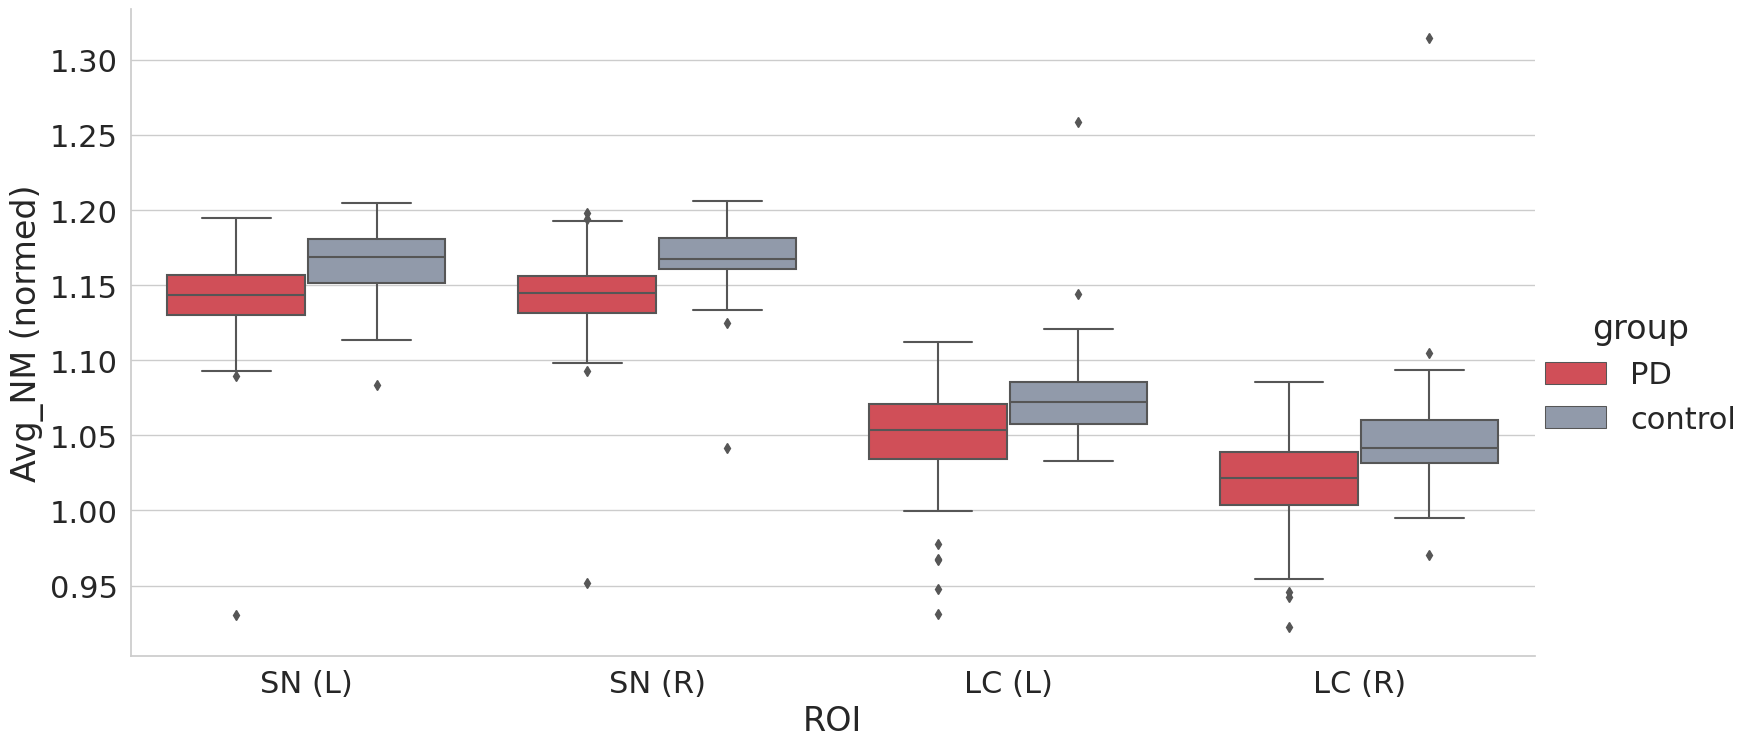

In [81]:
save_fig = True

demo_cols = ["participant_id", "diagnosis_group_for_analysis","visit"]
plot_groups = ["control","PD"]
nm_cols_dict = {"SN_L_AVG_NORM": "SN (L)", "SN_R_AVG_NORM": "SN (R)", 
                "LC_L_AVG_NORM": "LC (L)", "LC_R_AVG_NORM": "LC (R)"}
nm_df = nm_df.rename(columns=nm_cols_dict)
nm_cols = list(nm_cols_dict.values())
nm_df = nm_df[nm_df["diagnosis_group_for_analysis"].isin(plot_groups)][demo_cols + nm_cols]

nm_df_melt = nm_df.melt(
    id_vars=demo_cols, 
    var_name="ROI", 
    value_name="Avg_NM (normed)")

plot_df = nm_df_melt.copy()
plot_df["group"] = plot_df["diagnosis_group_for_analysis"] # rename for plotting

n_participants = plot_df["participant_id"].nunique()
print(f"n_participants: {n_participants}")

participants_per_group = plot_df.groupby(["group"])["participant_id"].nunique()
print(f"participants_per_group: {participants_per_group}")

sns.set_theme(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="ROI",y="Avg_NM (normed)", hue="group", kind="box",palette=palette, data=plot_df, aspect=2, height=8)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    print(f"Saving figure to {figs_dir}")
    g.savefig(f"{figs_dir}/NM.png")